# Implementando Redes Neurais Convolucionais para quantificar porosidade 

# Oque são Redes Neurais

Redes neurais sao sistemas de computacao com nos interconectados que funcionam como os neuronios do cerebro humano. Usando algoritmos, elas podem reconhecer padroes escondidos e correlacoes em dados brutos, agrupá-los e classificá-los, e – com o tempo – aprender e melhorar continuamente.



# Estrutura básica

Uma rede neural basica consiste em camadas de neuronios. Todo o processo comeca na camada de entrada onde a informacao ou solicitacao é recebida. A camada de entrada o transforma em um formato numerico que é compreensivel para a maquina.

Esses dados sao transmitidos aos neuronios das camadas ocultas e processados de acordo com as formulas ja incorporadas. Os neuronios sempre produzem um unico valor, nao importa quantas conexoes de saida eles tenham.

A resposta dos neuronios depende dos coeficientes desenvolvidos durante o treinamento. Esses coeficientes sao chamados de pesos. Esses coeficientes funcionam como memoria: a rede neural lembra como responder a dados com caracteristicas semelhantes.

Na ultima camada de saida, a rede neural tira uma conclusao e termina de processar a solicitacao.

# Redes Neurais Convolucionais


Camada Convolucional: Esta camada extrai recursos de alto nivel dos dados de entrada e os repassa para a proxima camada na forma de mapas de recursos.

Camada de Pooling: É usada para reduzir as dimensoes dos dados aplicando camadas de agrupamento (Pooling). Essa camada recebe cada saída do mapa de recursos da camada convolucional e prepara um mapa de caracteristicas condensadas.

Camada Totalmente Conectada: Finalmente, a tarefa de classificacao é feita pela camada totalmente conectada. As pontuacoes de probabilidade sao calculadas para cada rotulo de classe por uma funcao de ativacao popularmente chamada de funcao softmax.

# Dataset

Dataset composto por imagens digitais obtidas a partir da aquisicao por microscopia fotonica com luz polarizada de lamina delgada de amostras de calcarios da Formacao Barra Velha no poço 9-BRSA-0706-RJ, campo de Berbigao, bacia sedimentar de Santos.

# Importando bibliotecas

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Carregando os dados

In [5]:
import pandas as pd

# Definindo o caminho para o arquivo CSV
path_train= r'Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\df_train.csv'
path_test= r'Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\df_test.csv'
# Carregando o arquivo CSV no DataFrame do pandas
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

# Geradores Keras

A classe ImageDataGenerator do modulo tensorflow.keras.preprocessing.image e utilizada para preparar geradores de dados que serao usados para treinar, validar e testar um modelo de aprendizado profundo. Esses geradores de dados sao configurados para carregar imagens a partir de um diretorio e as correspondentes etiquetas de um dataframe.

In [6]:
# Criação do ImageDataGenerator com data augmentation e split de validação
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\images',
    x_col='id',
    y_col='porosidade',
    target_size=(120,120),
    batch_size=32,
    class_mode='raw',
    subset='training',
    shuffle=True
)

Found 54 validated image filenames.


C:\Users\theocf\AppData\Local\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [8]:
val_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\images',
    x_col='id',
    y_col='porosidade',
    target_size=(120, 120),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    shuffle=True
)


Found 13 validated image filenames.


In [9]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\images',
    x_col='id',
    y_col='porosidade',
    target_size=(120, 120),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 13 validated image filenames.


C:\Users\theocf\AppData\Local\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


dataframe=train_df: Indica que os dados de treinamento estao no dataframe train_df.

directory='/content/drive/MyDrive/calculo-porosidade/dataset/images': Diretorio onde as imagens estao armazenadas.

x_col='id': Coluna do dataframe que contem os nomes dos arquivos de imagem.

y_col='porosidade': Coluna do dataframe que contem os rotulos/valores alvo (porosidade).

target_size=(120,120): As imagens serao redimensionadas para 120x120 pixels.

batch_size=32: Tamanho do lote de imagens processadas de cada vez.

class_mode='raw': As etiquetas nao sao categorias, mas valores continuos.

subset='training': Indica que este gerador e para o conjunto de treinamento.

shuffle=True: Os dados serao embaralhados a cada epoca.

In [10]:
# Número de amostras em cada gerador
num_train_samples = train_generator.samples
num_val_samples = val_generator.samples
num_test_samples = test_generator.samples

print(f"Número de imagens para treinamento: {num_train_samples}")
print(f"Número de imagens para validacao: {num_val_samples}")
print(f"Número de imagens para teste: {num_test_samples}")

Número de imagens para treinamento: 54
Número de imagens para validacao: 13
Número de imagens para teste: 13


In [12]:
import matplotlib.pyplot as plt

# Função para exibir um lote de imagens
def show_images(images, labels, n=5):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Mostrar as primeiras 5 imagens do lote
show_images(images, labels, n=5)

NameError: name 'images' is not defined

# Definindo a Arquitetura


Entrada:
input_shape=(120, 120, 3): Especifica a forma da entrada como 120x120 pixels com 3 canais de cor (RGB).
Camadas Convolucionais e de Pooling:

Conv2D(75, (3, 3), strides=1, padding="same", activation="relu"): Primeira camada convolucional com 75 filtros de tamanho 3x3, strides de 1, padding "same" e ativação ReLU.


MaxPool2D((2, 2), strides=2, padding="same"): Camada de pooling máximo que reduz a dimensionalidade pela metade.


Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"): Segunda camada convolucional com 50 filtros de tamanho 3x3, strides de 1, padding "same" e ativação ReLU.


MaxPool2D((2, 2), strides=2, padding="same"): Outra camada de pooling máximo.


Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"): Terceira camada convolucional com 25 filtros de tamanho 3x3, strides de 1, padding "same" e ativação ReLU.


MaxPool2D((2, 2), strides=2, padding="same"): Outra camada de pooling máximo.
Camada de Flatten:



Flatten(): Transforma a saída 2D em 1D para a entrada na camada densa.
Camadas Densas:



Dense(units=512, activation="relu"): Camada densa com 512 unidades e ativação ReLU.
Saída:



Dense(units=1, activation="linear"): Camada de saída com 1 unidade e ativação linear para regressão. 

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(120, 120, 3)))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=1, activation="linear"))

# Treinamento do Modelo 

In [15]:
model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
           restore_best_weights=True
        )
    ]
)

Epoch 1/100
2/2 [==============================] - 2s 847ms/step - loss: 635.0865 - val_loss: 227.6867
Epoch 2/100
2/2 [==============================] - 1s 430ms/step - loss: 110.9445 - val_loss: 31.6825
Epoch 3/100
2/2 [==============================] - 1s 422ms/step - loss: 37.6179 - val_loss: 322.6353
Epoch 4/100
2/2 [==============================] - 1s 586ms/step - loss: 80.4953 - val_loss: 25.4406
Epoch 5/100
2/2 [==============================] - 1s 609ms/step - loss: 16.7700 - val_loss: 25.0956
Epoch 6/100
2/2 [==============================] - 1s 442ms/step - loss: 16.0806 - val_loss: 19.2840
Epoch 7/100
2/2 [==============================] - 1s 747ms/step - loss: 11.8534 - val_loss: 15.3513
Epoch 8/100
2/2 [==============================] - 1s 418ms/step - loss: 10.3551 - val_loss: 8.4170
Epoch 9/100
2/2 [==============================] - 1s 420ms/step - loss: 10.9730 - val_loss: 15.1784
Epoch 10/100
2/2 [==============================] - 1s 615ms/step - loss: 11.1202 - val_

In [18]:
predicted_porosity = np.squeeze(model.predict(test_generator))
true_porosity = test_generator.labels

1/1 [==============================] - 0s 479ms/step


# Avaliando o Modelo

In [19]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Calcular o erro médio absoluto e o erro quadrático médio
mae = mean_absolute_error(true_porosity, predicted_porosity)
mse = mean_squared_error(true_porosity, predicted_porosity)

print(f"Erro Medio Absoluto (MAE): {mae}")
print(f"Erro Quadrático Medio (MSE): {mse}")


Erro Medio Absoluto (MAE): 2.878764174534724
Erro Quadrático Medio (MSE): 12.282978010761715


# Grafico de Comparacao

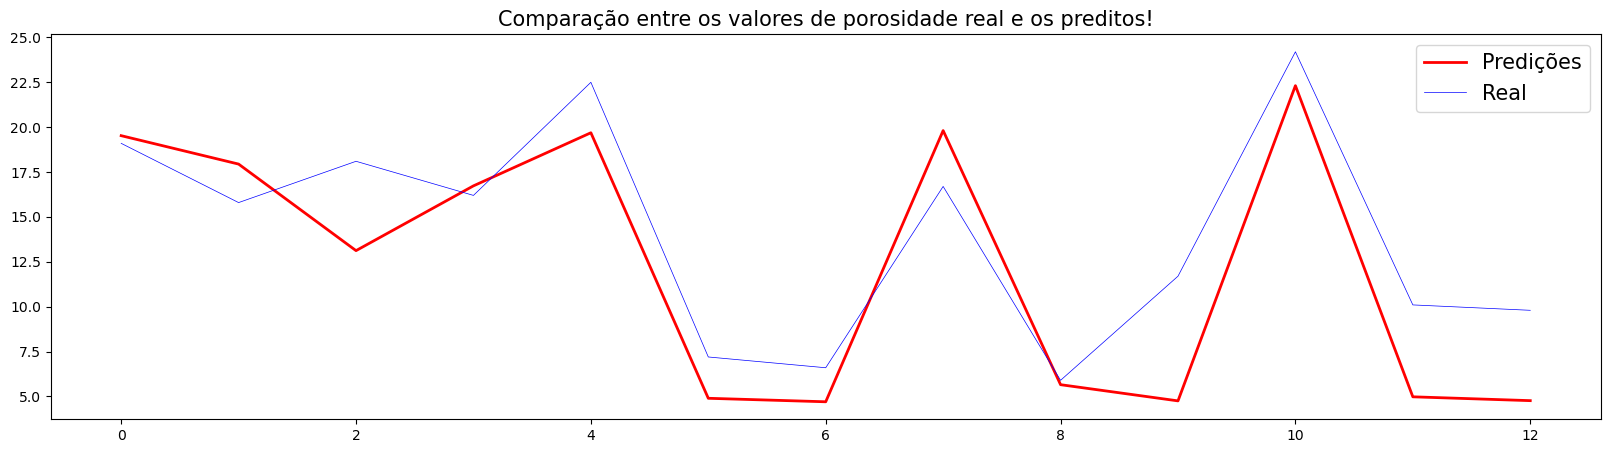

In [20]:
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(predicted_porosity[:150], linewidth=2, color='r')
plt.plot(true_porosity[:150], linewidth=0.5,color='b')
plt.title('Comparação entre os valores de porosidade real e os preditos!',size=15)
plt.legend(['Predições','Real'],fontsize=15)
plt.show()

In [21]:
model.save("Y:\ALUNOS\PRESAL2\EXOCARB\GRADUACAO\THEO COHEN\Atividades - Théo Cohen Farhat - 2023&2024\dataset\modelo-porosidade.h5")

C:\Users\theocf\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
